
# Simulator-based unsupervised detection and tracking of worms

**References**

    1. Wu, Hao, et al. Amortized population Gibbs samplers with neural
       sufficient statistics. ICML 2020.

<img src="file://../_static/wormsim.gif" align="center">


In [1]:
import argparse
from functools import partial

import coix
import flax.linen as nn
import jax
from jax import random
import jax.numpy as jnp
import numpy as np
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import optax
from optax import cosine_decay_schedule
from optax import clip_by_global_norm
import tensorflow as tf
import tensorflow_datasets as tfds

from sim_utils import *

/home/frans/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-04 21:33:40.641236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 21:33:40.651343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 21:33:40.654222: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-04 21:33:41.163567: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fi

In [2]:
def dataset_generator(file_path, n_data=-1):
    ds = np.load(file_path, mmap_mode='r')
    ds = ds[:n_data] if n_data != -1 else ds
    for data in ds:
        yield data

def load_dataset(*, is_training, batch_size, n_data=-1, file_path="worms_train_20k.npy"):
    # Create a dataset from the generator
    ds = tf.data.Dataset.from_generator(
        dataset_generator,
        args=(file_path, n_data),
        output_signature=tf.TensorSpec(shape=(None, None, None), dtype=tf.float32)
    )
    
    ds = ds.repeat()
    if is_training:
        ds = ds.shuffle(10 * batch_size, seed=0)
    ds = ds.batch(batch_size)
    
    # Standardize the data between 0 and 1
    ds = ds.map(lambda x: x / 0.80999994)
    return iter(tfds.as_numpy(ds))

def get_digit_mean():
  ds, ds_info = tfds.load("mnist:3.0.1", split="train", with_info=True)
  ds = tfds.as_numpy(ds.batch(ds_info.splits["train"].num_examples))
  digit_mean = next(iter(ds))["image"].squeeze(-1).mean(axis=0)
  return digit_mean / 255

In [3]:
def vmapped_sim_fn(sim_fn, params):
    if params['L'].ndim == 1:
        return jax.vmap(sim_fn, in_axes=0, out_axes=0)(params)
    else:
        return jax.vmap(partial(vmapped_sim_fn, sim_fn), in_axes=0, out_axes=0)(params)

In [4]:
def sim_worms(nworms, n_frames):
    duration = 1.55
    snapshots = 10
    kpoints = 6
    box_size = 64
    L = numpyro.sample('L', dist.Uniform(23, 28).expand([nworms]).to_event())
    A = numpyro.sample('A', dist.Normal(1, 0.1).expand([nworms]).to_event())
    T = numpyro.sample('T', dist.Normal(0.8, 0.1).expand([nworms]).to_event())
    kw = numpyro.sample('kw', dist.Uniform(0, 2 * jnp.pi).expand([nworms]).to_event())
    ku = numpyro.sample('ku', dist.Normal(jnp.pi, 1).expand([nworms]).to_event())

    inc = numpyro.sample('inc', dist.Uniform(0, 2 * jnp.pi).expand([nworms]).to_event())
    dr = numpyro.sample('dr', dist.Uniform(0.2, 0.8).expand([nworms]).to_event())
    phase_1 = numpyro.sample('phase_1', dist.Uniform(0, 2 * jnp.pi).expand([nworms]).to_event())
    phase_2 = numpyro.sample('phase_2', dist.Uniform(0, 2 * jnp.pi).expand([nworms]).to_event())
    phase_3 = numpyro.sample('phase_3', dist.Normal(0, 0.1).expand([nworms]).to_event())
    alpha = numpyro.sample('alpha', dist.Normal(4, 4).expand([nworms]).to_event())
    alpha = jnp.abs(alpha + 1.0)

    x0 = numpyro.sample('x0', dist.Uniform(-1, 1).expand([nworms]).to_event())
    y0 = numpyro.sample('y0', dist.Uniform(-1, 1).expand([nworms]).to_event())

    params = {'L': L, 'A': A, 'T': T, 'kw': kw, 'ku': ku, 'inc': inc, 'dr': dr, 'phase_1': phase_1, 'phase_2': phase_2, 'phase_3': phase_3, 'alpha': alpha, 'x0': x0, 'y0': y0}
    sim_fn = partial(
        worm_simulation,
        duration=duration,
        snapshots=snapshots,
        kpoints=kpoints,
    )
    worms = vmapped_sim_fn(sim_fn, params)
    batch_size = worms.shape[1]
    # normalize the worms
    worms = worms - jnp.array([x0, y0]).reshape(-1, batch_size, nworms, 1, 1, 2)
    worms = worms / ((28 + 23) / 2)
    numpyro.deterministic('worms', worms)
    return worms, x0, y0

In [5]:
def scale_and_translate(image, where, out_size):
  translate = abs(image.shape[-1] - out_size) * (where[..., ::-1] + 1) / 2
  return jax.image.scale_and_translate(
      image,
      (out_size, out_size),
      (0, 1),
      jnp.ones(2),
      translate,
      method="cubic",
      antialias=False,
  )

def scale_and_translate_variable_scale(image, where, scale, out_size):
  translate = abs(image.shape[-1] - out_size) * (where[..., ::-1] + 1) / 2
  return jax.image.scale_and_translate(
      image,
      (out_size, out_size),
      (0, 1),
      scale * jnp.ones(2),
      translate,
      method="cubic",
      antialias=False,
  )

def crop_frames(frames, z_where, digit_size=28):
  # frames:           time.frame_size.frame_size
  # z_where: (worm_frames).time.2
  # out:     (digits).time.digit_size.digit_size
  if frames.ndim == 2 and z_where.ndim == 1:
    return scale_and_translate(frames, z_where, out_size=digit_size)
  elif frames.ndim == 3 and z_where.ndim == 2:
    in_axes = (0, 0)
  elif frames.ndim == 3 and z_where.ndim == 3:
    in_axes = (None, 0)
  elif frames.ndim == z_where.ndim:
    in_axes = (0, 0)
  elif frames.ndim > z_where.ndim:
    in_axes = (0, None)
  else:
    in_axes = (None, 0)
  return jax.vmap(partial(crop_frames, digit_size=digit_size), in_axes)(
      frames, z_where
  )


def embed_frames(worm_frames, z_where, frame_size=64):
  # worm_frames:  (worm_frames).      .digit_size.digit_size
  # z_where: (worm_frames).(time).2
  # out:     (worm_frames).(time).frame_size.frame_size
  if worm_frames.ndim == 2 and z_where.ndim == 1:
    return scale_and_translate(worm_frames, z_where, out_size=frame_size)
  elif worm_frames.ndim == 2 and z_where.ndim == 2:
    in_axes = (None, 0)
  elif worm_frames.ndim >= z_where.ndim:
    in_axes = (0, 0)
  else:
    in_axes = (None, 0)
  # print("in_axes", in_axes)
  # print(worm_frames.shape)
  # print(z_where.shape)
  return jax.vmap(partial(embed_frames, frame_size=frame_size), in_axes)(
      worm_frames, z_where
  )

def embed_worms(worm_frames, z_where, scale, frame_size=64):
  # worm_frames:  (worm_frames).      .digit_size.digit_size
  # z_where: (worm_frames).(time).2
  # out:     (worm_frames).(time).frame_size.frame_size
  if worm_frames.ndim == 2 and z_where.ndim == 1:
    return scale_and_translate_variable_scale(worm_frames, z_where, scale, out_size=frame_size)
  elif worm_frames.ndim == 2 and z_where.ndim == 2:
    in_axes = (None, 0, 0)
  elif worm_frames.ndim >= z_where.ndim:
    in_axes = (0, 0, 0)
  else:
    in_axes = (None, 0, 0)
  return jax.vmap(partial(embed_worms, frame_size=frame_size), in_axes)(
      worm_frames, z_where, scale
  )

def conv2d(frames, worm_frames):
  # frames:          (time).frame_size.frame_size
  # worm_frames: (worm_frames).      .digit_size.digit_size
  # out:    (worm_frames).(time).conv_size .conv_size
  if frames.ndim == 2 and worm_frames.ndim == 2:
    return jax.scipy.signal.convolve2d(frames, worm_frames, mode="valid")
  elif frames.ndim == worm_frames.ndim:
    in_axes = (0, 0)
  elif frames.ndim > worm_frames.ndim:
    in_axes = (0, None)
  else:
    in_axes = (None, 0)
  return jax.vmap(conv2d, in_axes=in_axes)(frames, worm_frames)

# generate a size x size image of  circle
def circle_image(size):
    x = jnp.linspace(-1, 1, size)
    y = jnp.linspace(-1, 1, size)
    xx, yy = jnp.meshgrid(x, y)
    circle = jnp.exp(-(xx ** 2 + yy ** 2)/0.4)
    circle /= circle.max()
    circle += jnp.abs(circle.min())
    return circle

# interpolate the sparse points outputted by the simulator
def interpolate(worms, n_points=32):
  if worms.ndim == 1:
    return jnp.interp(jnp.linspace(0, 1, n_points), jnp.linspace(0, 1, worms.shape[0]), worms)
  elif worms.ndim == 2:
    return jax.vmap(partial(interpolate, n_points=n_points), in_axes=1, out_axes=1)(worms)
  else:
    return jax.vmap(partial(interpolate, n_points=n_points), in_axes=0)(worms)
    
# class EncoderWhat(nn.Module):

#   @nn.compact
#   def __call__(self, worm_frames):
#     x = worm_frames.reshape(worm_frames.shape[:-2] + (-1,)) # flatten frame into vector
#     x = nn.Dense(400)(x)
#     x = nn.relu(x)
#     x = nn.Dense(200)(x)
#     x = nn.relu(x)

#     x = x.sum(-2)  # sum/mean across time
#     loc_raw = nn.Dense(10)(x)
#     scale_raw = 0.5 * nn.Dense(10)(x)
#     return loc_raw, jnp.exp(scale_raw)


In [6]:
class EncoderWhat(nn.Module):
  """
  Takes all worm frames and encodes them into a distribution over worm simulator parameters
  """

  @nn.compact
  def __call__(self, worm_frames, carry=None):
    mappable_dims = worm_frames.shape[:-3]
    
    hidden_dim = 128

    x = worm_frames.reshape(worm_frames.shape[:-2] + (-1,)) # flatten frame into vector
    if carry is None:
      carry = self.param('carry_init', 
                         lambda rng, shape: jnp.zeros(shape), 
                         mappable_dims + (hidden_dim,))
    GRU = nn.scan(nn.GRUCell,
                  in_axes=-1,
                  variable_broadcast='params',
                  split_rngs={'params': False}
                  )(hidden_dim)
    # print(carry.shape)
    # print(x.shape)
    # add layernorm
    
    x = nn.LayerNorm()(x)
    x,_ = GRU(carry, x)
    x = nn.relu(x)
    x = nn.Dense(64)(x)
    x = nn.relu(x)
    x = nn.LayerNorm()(x)
    
    x_L = nn.Dense(10)(x)
    x_L = nn.relu(x_L)
    x_L_loc = nn.Dense(1)(x_L)
    # scale to 10-15
    x_L_loc = nn.tanh(x_L_loc) * ((28 - 23) / 2) + (23 + 28) / 2
    x_L_scale = 0.5 * nn.Dense(1)(x_L)

    x_A = nn.Dense(10)(x)
    x_A = nn.relu(x_A)
    x_A_loc = nn.Dense(1)(x_A)
    x_A_scale = 0.5 * nn.Dense(1)(x_A)

    x_T = nn.Dense(10)(x)
    x_T = nn.relu(x_T)
    x_T_loc = nn.Dense(1)(x_T)
    # constrain to positive
    x_T_loc = nn.softplus(x_T_loc)
    x_T_scale = 0.5 * nn.Dense(1)(x_T)

    x_kw = nn.Dense(10)(x)
    x_kw = nn.relu(x_kw)
    x_kw_loc = nn.Dense(1)(x_kw)
    # scale to 0-2pi
    x_kw_loc = nn.tanh(x_kw_loc) * jnp.pi + jnp.pi
    x_kw_scale = 0.5 * nn.Dense(1)(x_kw)

    x_ku = nn.Dense(10)(x)
    x_ku = nn.relu(x_ku)
    x_ku_loc = nn.Dense(1)(x_ku)
    x_ku_scale = 0.5 * nn.Dense(1)(x_ku)

    x_inc = nn.Dense(10)(x)
    x_inc = nn.relu(x_inc)
    x_inc_loc = nn.Dense(1)(x_inc)
    # scale to 0-2pi
    x_inc_loc = nn.tanh(x_inc_loc) * jnp.pi + jnp.pi
    x_inc_scale = 0.5 * nn.Dense(1)(x_inc)

    x_dr = nn.Dense(10)(x)
    x_dr = nn.relu(x_dr)
    x_dr_loc = nn.Dense(1)(x_dr)
    # scale to 0.2-0.8
    x_dr_loc = nn.tanh(x_dr_loc) * 0.3 + 0.5
    x_dr_scale = 0.5 * nn.Dense(1)(x_dr)

    x_phase_1 = nn.Dense(10)(x)
    x_phase_1 = nn.relu(x_phase_1)
    x_phase_1_loc = nn.Dense(1)(x_phase_1)
    # scale to 0-2pi
    x_phase_1_loc = nn.tanh(x_phase_1_loc) * jnp.pi + jnp.pi
    x_phase_1_scale = 0.5 * nn.Dense(1)(x_phase_1)

    x_phase_2 = nn.Dense(10)(x)
    x_phase_2 = nn.relu(x_phase_2)
    x_phase_2_loc = nn.Dense(1)(x_phase_2)
    # scale to 0-2pi
    x_phase_2_loc = nn.tanh(x_phase_2_loc) * jnp.pi + jnp.pi
    x_phase_2_scale = 0.5 * nn.Dense(1)(x_phase_2)

    x_phase_3 = nn.Dense(10)(x)
    x_phase_3 = nn.relu(x_phase_3)
    x_phase_3_loc = nn.Dense(1)(x_phase_3)
    x_phase_3_scale = 0.5 * nn.Dense(1)(x_phase_3)

    x_alpha = nn.Dense(10)(x)
    x_alpha = nn.relu(x_alpha)
    x_alpha_loc = nn.Dense(1)(x_alpha)
    x_alpha_scale = 0.5 * nn.Dense(1)(x_alpha)

    x_x0_loc = nn.Dense(1)(x)
    x_x0_loc = nn.tanh(x_x0_loc) * 1
    x_x0_scale = 0.5 * nn.Dense(1)(x)

    x_y0_loc = nn.Dense(1)(x)
    x_y0_loc = nn.tanh(x_y0_loc) * 1
    x_y0_scale = 0.5 * nn.Dense(1)(x)

    return x_L_loc.squeeze(-1), jnp.exp(x_L_scale.squeeze(-1)), x_A_loc.squeeze(-1), jnp.exp(x_A_scale.squeeze(-1)), x_T_loc.squeeze(-1), jnp.exp(x_T_scale.squeeze(-1)), x_kw_loc.squeeze(-1), jnp.exp(x_kw_scale.squeeze(-1)), x_ku_loc.squeeze(-1), jnp.exp(x_ku_scale.squeeze(-1)), x_inc_loc.squeeze(-1), jnp.exp(x_inc_scale.squeeze(-1)), x_dr_loc.squeeze(-1), jnp.exp(x_dr_scale.squeeze(-1)), x_phase_1_loc.squeeze(-1), jnp.exp(x_phase_1_scale.squeeze(-1)), x_phase_2_loc.squeeze(-1), jnp.exp(x_phase_2_scale.squeeze(-1)), x_phase_3_loc.squeeze(-1), jnp.exp(x_phase_3_scale.squeeze(-1)), x_alpha_loc.squeeze(-1), jnp.exp(x_alpha_scale.squeeze(-1)), x_x0_loc.squeeze(-1), jnp.exp(x_x0_scale.squeeze(-1)), x_y0_loc.squeeze(-1), jnp.exp(x_y0_scale.squeeze(-1))



# class EncoderWhere(nn.Module):
#   """
#   MLP to encode the frame into a distribution over worm locations
#   """
#   @nn.compact
#   def __call__(self, frame_conv):
#     x = frame_conv.reshape(frame_conv.shape[:-2] + (-1,))
#     x = nn.softmax(x, -1)
#     x = nn.Dense(200)(x)
#     x = nn.relu(x)
#     x = nn.Dense(200)(x)
#     x = x.reshape(x.shape[:-1] + (2, 100))
#     x = nn.relu(x)
#     loc_raw = nn.Dense(2)(x[..., 0, :])
#     scale_raw = 0.5 * nn.Dense(2)(x[..., 1, :])
#     return nn.tanh(loc_raw), jnp.exp(scale_raw)


class EncoderWhere(nn.Module):
  # a CNN to encode the frame into a distribution over worm locations
  @nn.compact
  def __call__(self, frame_conv):
    x = jnp.expand_dims(frame_conv, -1)
    x = nn.Conv(features=8, kernel_size=(3, 3), strides=(2, 2))(x)
    x = nn.relu(x)
    x = nn.Conv(features=16, kernel_size=(3, 3), strides=(2, 2))(x)
    x = nn.relu(x)
    x = x.reshape(x.shape[:-3] + (-1,))
    x = nn.Dense(128)(x)
    x = x.reshape(x.shape[:-1] + (2, 64))
    x = nn.relu(x)
    loc_raw = nn.Dense(2)(x[..., 0, :])
    scale_raw = 0.5 * nn.Dense(2)(x[..., 1, :])
    return nn.tanh(loc_raw), jnp.exp(scale_raw)

class DecoderWhat(nn.Module):
  """
  Hardcoded decoder to plot worm coordinates on a frame
  """
  @nn.compact
  def __call__(self, worms):
    # vmap interpolate over all worms
    worms = interpolate(worms, n_points = 12)    

    # make worm widths for all knots
    # R = 0.8
    R = nn.softplus(nn.Dense(1)(jnp.ones(1))) + 0.6
    worm_scale = nn.softplus(nn.Dense(1)(jnp.ones(1))) * 2
    # print("R:", R)
    K = worms.shape[-2]
    i = jnp.arange(K)
    r = R * jnp.abs(jnp.sin(jnp.arccos((i - K / 2) / (K / 2 + 0.2))))
    r = jnp.tile(r, (worms.shape[:-2] + (1,)))

    # draw the circles
    circles = embed_worms(circle_image(4), worms * worm_scale, r, frame_size=28)
    # overlay the circles
    p = dist.util.clamp_probs(circles.mean(-3))
    # # run p through a conv layer outputting the same shape
    # x = jnp.expand_dims(p, -1)
    # x = nn.Conv(features=8, kernel_size=(3, 3), strides=(1, 1))(x)
    # x = nn.relu(x)
    # x = nn.Conv(features=16, kernel_size=(3, 3), strides=(1, 1))(x)
    # x = nn.relu(x)
    # x = nn.Conv(features=1, kernel_size=(3, 3), strides=(1, 1))(x)
    # x = nn.sigmoid(x)
    # p = x.squeeze(-1)
    # print(p)
    return p


class wormsimAutoEncoder(nn.Module):
  digit_mean: jnp.ndarray
  frame_size: int


  def setup(self):
    self.encode_what = EncoderWhat()
    self.encode_where = EncoderWhere()
    self.decode_what = DecoderWhat()

  def __call__(self, frames):
    num_particles, batch_size, T, frame_size, frame_size = frames.shape
    # Heuristic procedure to setup initial parameters.

    z_where = []
    for t in range(10):
      frame = frames[..., t, :, :]
      z_where_d = []
      for d in range(2):
        frames_conv = conv2d(frame, self.digit_mean)
        z_where_t_d, _ = self.encode_where(frames_conv)
        z_where_d.append(z_where_t_d)
        if t == 0:
          print("frames_conv.max()", frames_conv.max())
          plt.figure()
          plt.imshow(frame[0,0])
          plt.figure()
          plt.imshow(self.digit_mean)
          plt.figure()
          plt.imshow(frames_conv[0,0])
          print(z_where_t_d[0,0])
      z_where_d = jnp.stack(z_where_d, -2)
      z_where.append(z_where_d)
    # z_where = jnp.stack(z_where, -3).transpose(0, 2, 1, 3)

    z_where = jnp.stack(z_where, -3)
    z_where = z_where.transpose(0, 1, 3, 2, 4)

    # frames_conv = conv2d(frames, self.digit_mean)
    # z_where, _ = self.encode_where(frames_conv)
    # # print(z_where.shape)
    # z_where = z_where.transpose(1, 0, 2, 3)

    print("z_where.shape", z_where.shape)
    worm_frames = crop_frames(frames, z_where, 28)
    # print(worm_frames.shape)
    print("worm_frames.shape", worm_frames.shape)
    # z_what, _ = self.encode_what(worm_frames)
    proposed_sim_params = self.encode_what(worm_frames)
    print("L shape", proposed_sim_params[0].shape)
    # proposed_sim_params = jax.tree_map(lambda x: x.squeeze(-1), proposed_sim_params)
    # x0, y0 = z_where[..., 0, 0].squeeze(), z_where[..., 0, 1].squeeze()
    x0, y0 = z_where[..., 0, 0], z_where[..., 0, 1]
    assert x0.shape == proposed_sim_params[0].shape, f"x0.shape: {x0.shape}, proposed_sim_params[0].shape: {proposed_sim_params[0].shape}"
    worm_sim = numpyro.handlers.condition(sim_worms, {'L': proposed_sim_params[0], 'A': proposed_sim_params[2], 'T': proposed_sim_params[4], 'kw': proposed_sim_params[6], 'ku': proposed_sim_params[8], 'inc': proposed_sim_params[10], 'dr': proposed_sim_params[12], 'phase_1': proposed_sim_params[14], 'phase_2': proposed_sim_params[16], 'phase_3': proposed_sim_params[18], 'alpha': proposed_sim_params[20], 'x0': x0, 'y0': y0})
    worm_trace = numpyro.handlers.trace(worm_sim).get_trace(2, T)
    worms = worm_trace["worms"]["value"]
    # print(worms.shape)
    print("worms.shape", worms.shape)
    print(worms.mean(), worms.std())

    worm_frame_recon = self.decode_what(worms)
    # print(worm_frame_recon.shape)
    print("worm_frame_recon.shape", worm_frame_recon.shape)
    frames_recon = embed_frames(worm_frame_recon, z_where, self.frame_size)
    # print(frames_recon.shape)
    print("frames_recon.shape", frames_recon.shape)
    # plt.figure()
    # plt.imshow(frames_recon[0,0,0,0])
    # plt.figure()
    # plt.imshow(frames_recon[0,0,0,9])
    # check for nans
    if jnp.any(jnp.isnan(frames_recon)):
      print("frames_recon has nans")
    if jnp.any(jnp.isnan(worm_frame_recon)):
      print("worm_frame_recon has nans")
    if jnp.any(jnp.isnan(worms)):
      print("worms has nans")
      # print the proposed sim params where worms is nan
      print(proposed_sim_params[0][jnp.isnan(worms)])
    if jnp.any(jnp.isnan(worm_frames)):
      print("worm_frames has nans")
    if jnp.any(jnp.isnan(frames)):
      print("frames has nans")
    if jnp.any(jnp.isnan(z_where)):
      print("z_where has nans")
    return frames_recon

Then, we define the target and kernels as in Section 6.4.



In [7]:
def wormsim_target(network, inputs, D=2, T=10):
   
  worms, x0s, y0s = sim_worms(D, T)

  worm_frames = network.decode_what(worms)

  z_where = []
  for d in range(D):
    z_where_d = []
    # z_where_d_t = jnp.array([x0s[d], y0s[d]])
    z_where_d_t = jnp.zeros(2)
    for t in range(T):
      # worm_frame = network.decode_what(worms[..., t, d, :, :])
      # worm_frames.append(worm_frame)
      scale = 1 if t == 0 else 0.1
      z_where_d_t = numpyro.sample(
          f"z_where_{d}_{t}", dist.Normal(z_where_d_t, scale).to_event(1)
      )
      z_where_d.append(z_where_d_t)
    z_where_d = jnp.stack(z_where_d, -2)
    z_where.append(z_where_d)
  z_where = jnp.stack(z_where, -3)
  # z_where = z_where.squeeze()

  # print("worm_frames target", worm_frames.shape)
  # print("z_where target", z_where.shape)
  p = embed_frames(worm_frames, z_where, network.frame_size)
  # print("p.shape target", p.shape)
  p = dist.util.clamp_probs(p.sum(-4))  # sum across worm_frames
  # print("summed p.shape target", p.shape)
  # print("inputs.shape", inputs.shape)
  frames = numpyro.sample("frames", dist.Bernoulli(p).to_event(3), obs=inputs)

  out = {
      "frames": frames,
      "frames_recon": p,
      "worms": worms,
      "worm_frames": jax.lax.stop_gradient(worm_frames),
      **{f"z_where_{t}": z_where[..., t, :] for t in range(T)},
  }
  return (out,)


def kernel_where(network, inputs, D=2, t=0, T=10):
  if not isinstance(inputs, dict):
    # print('making inputs')
    inputs = {
        "frames": inputs,
        "worm_frames": jnp.tile(network.digit_mean, (D, T, 1, 1)),
    }

  frame = inputs["frames"][..., t, :, :]
  z_where_t = []

  for d in range(D):
    # print(inputs["worm_frames"].shape)
    worm_frame = inputs["worm_frames"][..., d, t, :, :]
    # worm_frame = inputs["worm_frames"][..., d, 0, :, :]
    # print("frame shape where", frame.shape)
    # print("worm_frame shape where", worm_frame.shape)
    x_conv = conv2d(frame, worm_frame)
    loc, scale = network.encode_where(x_conv)
    z_where_d_t = numpyro.sample(
        f"z_where_{d}_{t}", dist.Normal(loc, scale).to_event(1)
    )
    z_where_t.append(z_where_d_t)
    # print("worm_frame shape where", worm_frame.shape)
    # print("z_where_d_t shape where", z_where_d_t.shape)
    frame_recon = embed_frames(worm_frame, z_where_d_t, network.frame_size)
    # print("frame_recon shape where", frame_recon)
    frame = frame - frame_recon
    # if inputs["worm_frames"].ndim > 4:
    #   plt.figure()
    #   plt.imshow(frame[0, 0])
  z_where_t = jnp.stack(z_where_t, -2)
  # print("z_where_t.shape where", z_where_t.shape)
  out = {**inputs, **{f"z_where_{t}": z_where_t}}
  return (out,)


def kernel_what(network, inputs, T=10):
  z_where = jnp.stack([inputs[f"z_where_{t}"] for t in range(T)], -2)
  # print("z_where kernel what", z_where.shape)
  worm_frames = crop_frames(inputs["frames"], z_where, 28)
  # print("worm_frames what", worm_frames.shape)
  proposed_sim_params = network.encode_what(worm_frames)
  loc_L, scale_L, loc_A, scale_A, loc_T, scale_T, loc_kw, scale_kw, loc_ku, scale_ku, loc_inc, scale_inc, loc_dr, scale_dr, loc_phase_1, scale_phase_1, loc_phase_2, scale_phase_2, loc_phase_3, scale_phase_3, loc_alpha, scale_alpha, loc_x0, scale_x0, loc_y0, scale_y0 = proposed_sim_params
  L = numpyro.sample('L', dist.TruncatedNormal(loc_L, scale_L, low=23, high=28).to_event(1))
  A = numpyro.sample('A', dist.Normal(loc_A, scale_A).to_event(1))
  T = numpyro.sample('T', dist.Normal(loc_T, scale_T).to_event(1))
  kw = numpyro.sample('kw', dist.TruncatedNormal(loc_kw, scale_kw, low=0, high=2 * jnp.pi).to_event(1))
  ku = numpyro.sample('ku', dist.Normal(loc_ku, scale_ku).to_event(1))
  inc = numpyro.sample('inc', dist.TruncatedNormal(loc_inc, scale_inc, low=0, high=2 * jnp.pi).to_event(1))
  dr = numpyro.sample('dr', dist.TruncatedNormal(loc_dr, scale_dr, low=0.2, high=0.8).to_event(1))
  phase_1 = numpyro.sample('phase_1', dist.TruncatedNormal(loc_phase_1, scale_phase_1, low=0, high=2 * jnp.pi).to_event(1))
  phase_2 = numpyro.sample('phase_2', dist.TruncatedNormal(loc_phase_2, scale_phase_2, low=0, high=2 * jnp.pi).to_event(1))
  phase_3 = numpyro.sample('phase_3', dist.Normal(loc_phase_3, scale_phase_3).to_event(1))
  alpha = numpyro.sample('alpha', dist.Normal(loc_alpha, scale_alpha).to_event(1))
  x0 = numpyro.sample('x0', dist.TruncatedNormal(loc_x0, scale_x0, low=-1, high=1).to_event(1))
  y0 = numpyro.sample('y0', dist.TruncatedNormal(loc_y0, scale_y0, low=-1, high=1).to_event(1))

  out = {**inputs, **{'L': L, 'A': A, 'T': T, 'kw': kw, 'ku': ku, 'inc': inc, 'dr': dr, 'phase_1': phase_1, 'phase_2': phase_2, 'phase_3': phase_3, 'alpha': alpha, 'x0': x0, 'y0': y0}}
  return (out,)

Finally, we create the inference program, define the loss function,
run the training loop, and plot the results.



In [8]:
def make_wormsim(params, wormsim_net, T=10, num_sweeps=5, num_particles=10):
  network = coix.util.BindModule(wormsim_net, params)
  # Add particle dimension and construct a program.
  make_particle_plate = lambda: numpyro.plate("particle", num_particles, dim=-2)
  target = make_particle_plate()(partial(wormsim_target, network, D=2, T=T))
  kernels = []
  for t in range(T):
    kernels.append(
        make_particle_plate()(partial(kernel_where, network, D=2, t=t))
    )
  kernels.append(make_particle_plate()(partial(kernel_what, network, T=T)))
  program = coix.algo.apgs(target, kernels, num_sweeps=num_sweeps)
  return program


def loss_fn(params, key, batch, wormsim_net, num_sweeps, num_particles):
  # Prepare data for the program.
  shuffle_rng, rng_key = random.split(key)
  batch = random.permutation(shuffle_rng, batch, axis=1)
  T = batch.shape[-3]
  batch_size = batch.shape[-4]

  # Run the program and get metrics.
  program = make_wormsim(params, wormsim_net, T, num_sweeps, num_particles)
  _, _, metrics = coix.traced_evaluate(program, seed=rng_key)(batch)
  for metric_name in ["log_Z", "log_density", "loss"]:
    metrics[metric_name] = metrics[metric_name] / batch.shape[0]
  return metrics["loss"], metrics



In [9]:
class Args(argparse.Namespace):
  batch_size = 5
  # batch_size = 16
  num_sweeps = 5
  num_particles = 10
  # learning_rate = 1e-4
  learning_rate = 5e-5
  num_steps = 20000
  # num_steps = 4000
  # num_steps = 400
  device = "gpu"

args = Args()

I0000 00:00:1722800021.652013   49450 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-04 21:33:41.675955: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-08-04 21:33:42.780994: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.5.82). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilati

frames_conv.max() 10.946661
[ 0.24983479 -0.5324185 ]
frames_conv.max() 10.946661
[ 0.24983479 -0.5324185 ]
z_where.shape (10, 5, 2, 10, 2)
worm_frames.shape (10, 5, 2, 10, 28, 28)
L shape (10, 5, 2)
worms.shape (10, 5, 2, 10, 6, 2)
-0.0021980095 0.20317136
worm_frame_recon.shape (10, 5, 2, 10, 28, 28)
frames_recon.shape (10, 5, 2, 10, 64, 64)


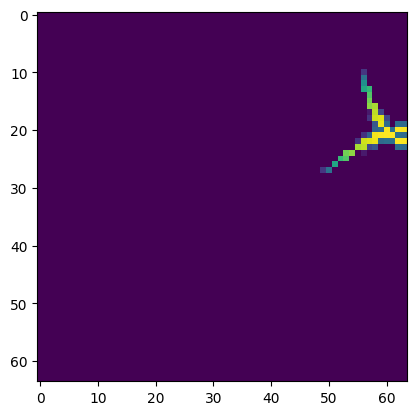

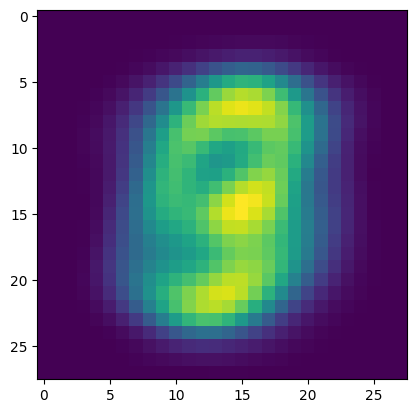

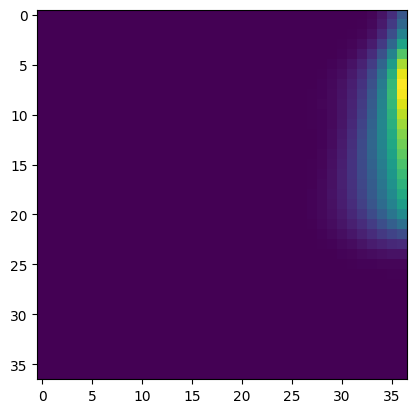

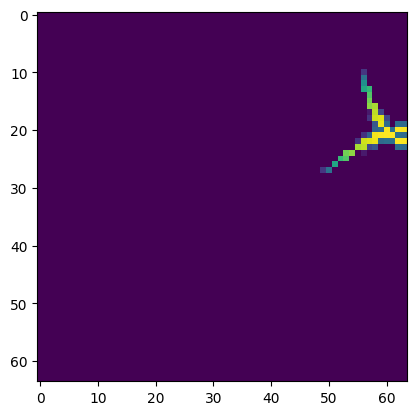

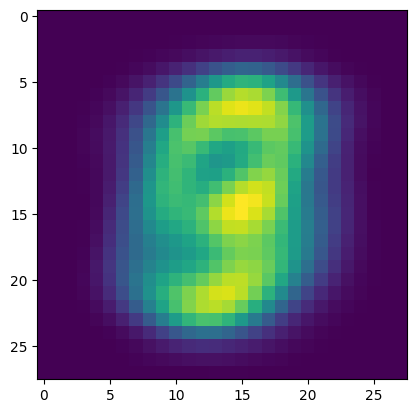

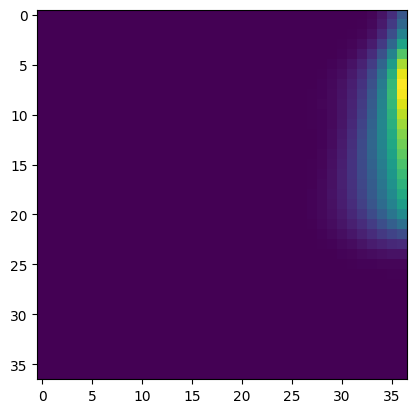

In [10]:
lr = args.learning_rate
num_steps = args.num_steps
batch_size = args.batch_size
num_sweeps = args.num_sweeps
num_particles = args.num_particles

# train_ds = load_dataset(is_training=True, batch_size=batch_size, n_data=512)
train_ds = load_dataset(is_training=True, batch_size=batch_size)

test_ds = load_dataset(is_training=False, batch_size=batch_size)
digit_mean = get_digit_mean()
# scale down digit_mean to half the size
# digit_mean = jax.image.resize(digit_mean, (14, 14), method="cubic")
test_data = next(test_ds)
frame_size = test_data.shape[-1]
wormsim_net = wormsimAutoEncoder(digit_mean=digit_mean, frame_size=frame_size)
test_data_tiled = np.tile(test_data, ((num_particles,) + ((1,) * test_data.ndim)))
init_params = wormsim_net.init(jax.random.PRNGKey(0), test_data_tiled)


In [11]:
# lr_schedule = cosine_decay_schedule(lr, num_steps, 0.1)
lr_schedule = cosine_decay_schedule(lr, num_steps, 1.0)

opt = optax.chain(
    # clip_by_global_norm(100.0),
    optax.adam(lr_schedule),
)

In [12]:
# with jax.disable_jit():
wormsim_params, _ = coix.util.train(
    partial(
        loss_fn,
        wormsim_net=wormsim_net,
        num_sweeps=num_sweeps,
        num_particles=num_particles,
    ),
    init_params,
    optax.adam(lr),
    # opt,
    num_steps,
    train_ds,
)


Compiling the first train step...
Time to compile a train step: 268.15601110458374
=====
Step 200  | ess     1.0000 | log_Z -38094.0625 | log_density -38727.7578 | loss 2088297.8750 | squared_grad_norm 149278624.0000
Step 400  | ess     1.0000 | log_Z -34842.6172 | log_density -35831.5000 | loss 1899390.2500 | squared_grad_norm 1182019328.0000
Step 600  | ess     1.0000 | log_Z -37280.7539 | log_density -38738.6406 | loss 2119061.7500 | squared_grad_norm 24462661517312.0000
Step 800  | ess     1.0087 | log_Z -27321.9531 | log_density -28404.4355 | loss 1526111.2500 | squared_grad_norm        nan
Step 1000 | ess     1.0000 | log_Z -37243.7188 | log_density -37874.4141 | loss 2022962.6250 | squared_grad_norm        nan
Step 1200 | ess     1.0000 | log_Z -32316.4258 | log_density -32940.8867 | loss 1765284.6250 | squared_grad_norm        nan
Step 1400 | ess     1.0000 | log_Z -37633.0000 | log_density -38361.6719 | loss 2081792.3750 | squared_grad_norm        nan
Step 1600 | ess     1.000

In [ ]:
# load worm_learned_params.npy

# wormsim_params = np.load("worm_learned_params.npy", allow_pickle=True).item()

np.save("worm_learned_params.npy", wormsim_params)

In [ ]:
T_test = test_data.shape[-3]
batch_size_test = test_data.shape[-4]
program = make_wormsim(
    wormsim_params, wormsim_net, T_test, num_sweeps, num_particles
)
out, _, _ = coix.traced_evaluate(program, seed=jax.random.PRNGKey(1))(
    test_data
)
out = out[0]


[19.861061 21.687584]
[14.792325 17.809973]
[19.861061 21.687584]
[14.792325 17.809973]
[16.035496 20.327515]
[17.651066 17.833147]
[17.162292 18.093773]
[19.117172 18.215656]
[17.957054 15.871813]
[17.143528 16.13142 ]
[17.730848 20.023596]
[16.617496 15.422094]
[18.937464 18.396397]
[16.208158 16.846384]
[20.180082 18.968409]
[13.097267 17.324863]
[19.305532 17.15989 ]
[14.642843 15.37998 ]
[16.425446 16.521524]
[15.726173 16.570015]
[18.405533 15.633905]
[15.683556 14.086058]


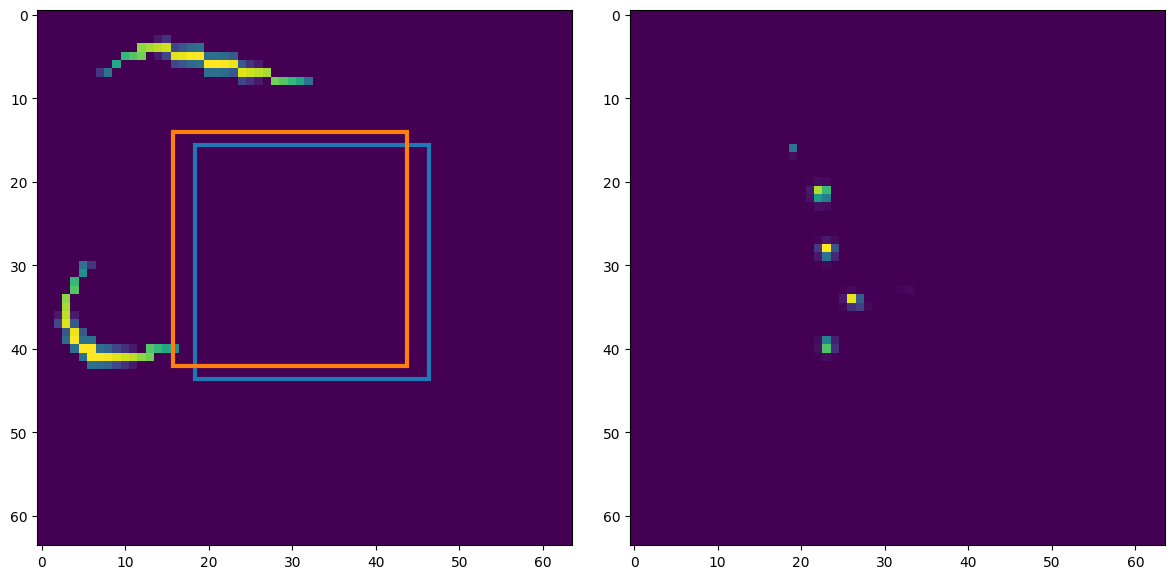

In [ ]:
b = 2
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
def animate(i):
  axes[0].cla()
  axes[0].imshow(test_data[b, i])
  axes[1].cla()
  axes[1].imshow(out["frames_recon"][0, b, i])
  for d in range(2):
    foo = out[f"z_where_{i}"][0, b, d]
    # foo = jnp.array([-1, 1])
    # print(foo)
    where = 0.5 * (foo + 1) * (frame_size - 28) - 0.5
    print(where)
    color = colors[d]
    axes[0].add_patch(
        Rectangle(where, 28, 28, edgecolor=color, lw=3, fill=False)
    )
plt.rc("animation", html="jshtml")
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=range(10), interval=300)
writer = animation.PillowWriter(fps=15)
ani.save("worms.gif", writer=writer)
plt.show()


[-0.07916344  0.00084398]
[16.075058 17.515192]
[ 0.38479003 -0.00790264]
[24.426222 17.357754]
[ 0.06178928 -0.11341339]
[18.612207 15.458559]
[0.15405542 0.03922314]
[20.272997 18.206017]
[ 0.08770626 -0.08807027]
[19.078712 15.914736]
[0.00860405 0.02400684]
[17.654873 17.932123]
[-0.00853873 -0.18469343]
[17.346302 14.175518]
[-0.02939842  0.00118952]
[16.970829 17.52141 ]
[ 0.07903044 -0.15303956]
[18.922546 14.745288]
[0.03765613 0.03639956]
[18.177809 18.155193]
[ 0.03354213 -0.07661463]
[18.10376  16.120937]
[0.06676772 0.07221554]
[18.701818 18.799881]
[0.05047451 0.00435749]
[18.40854  17.578434]
[-0.07029957  0.08608429]
[16.234608 19.049517]
[0.03909327 0.06910015]
[18.203678 18.743803]
[ 0.06027517 -0.01420082]
[18.584953 17.244385]
[-0.07227439  0.01272152]
[16.19906  17.728989]
[-0.00651292  0.0173061 ]
[17.382767 17.81151 ]
[-0.12710597 -0.14918113]
[15.212093 14.814739]
[-0.00076701  0.09150033]
[17.486195 19.147005]


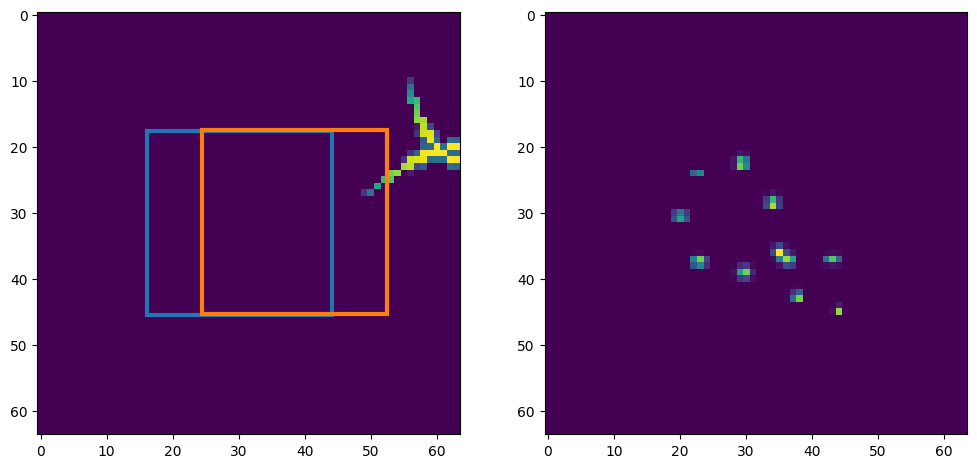

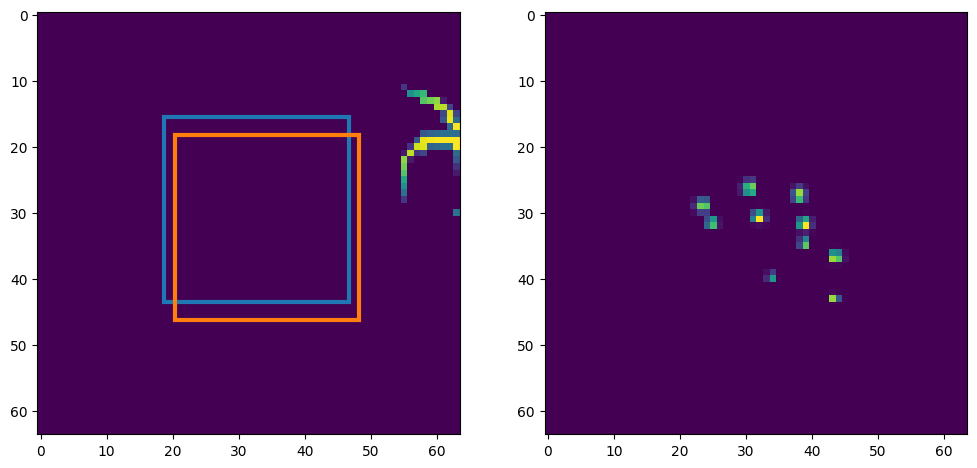

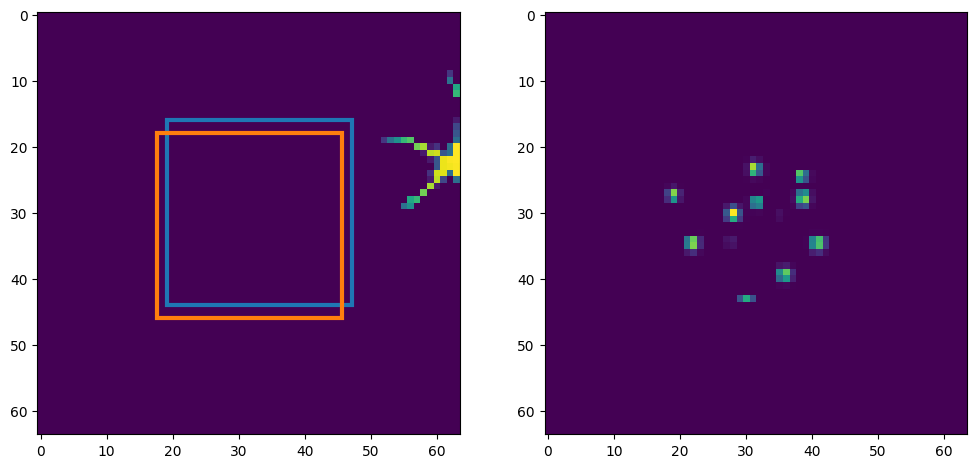

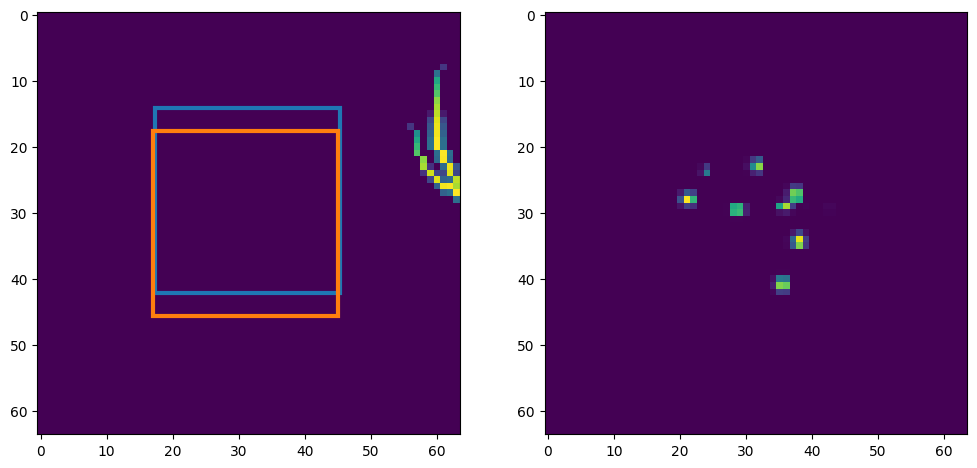

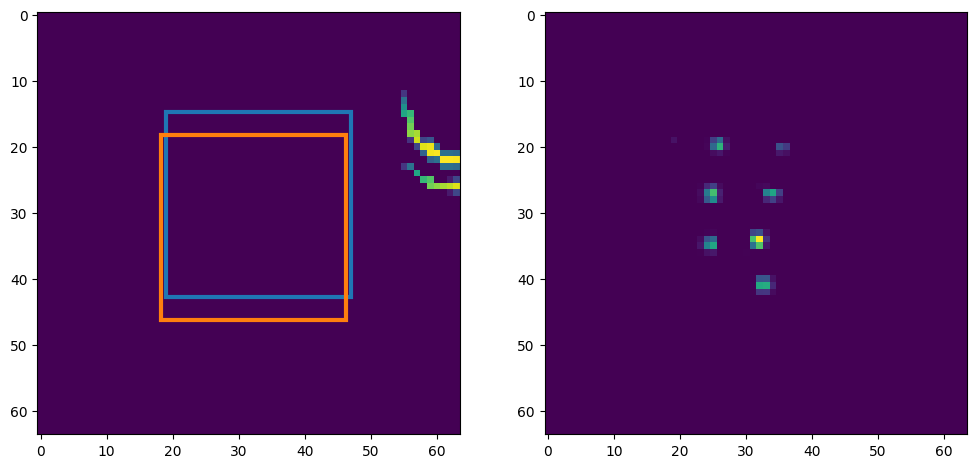

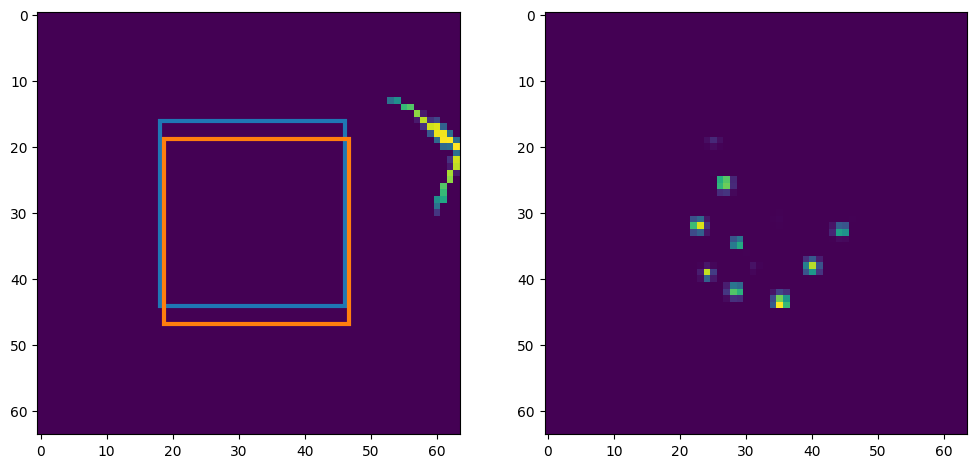

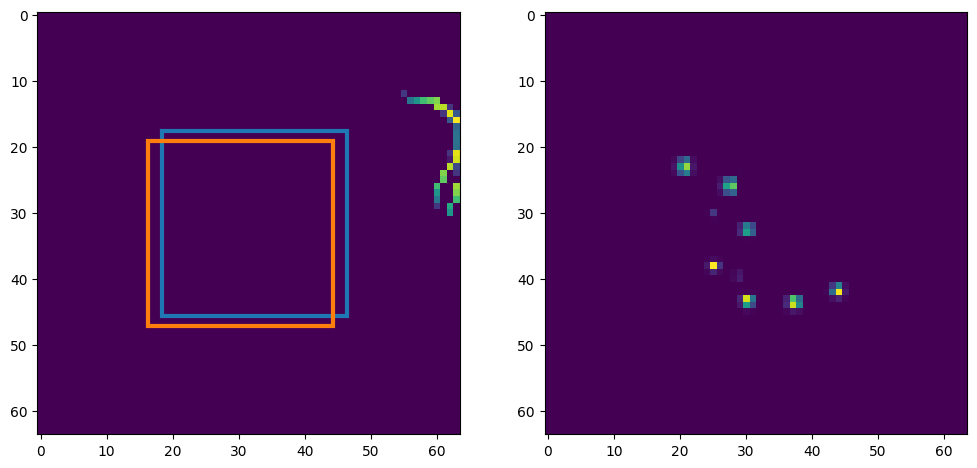

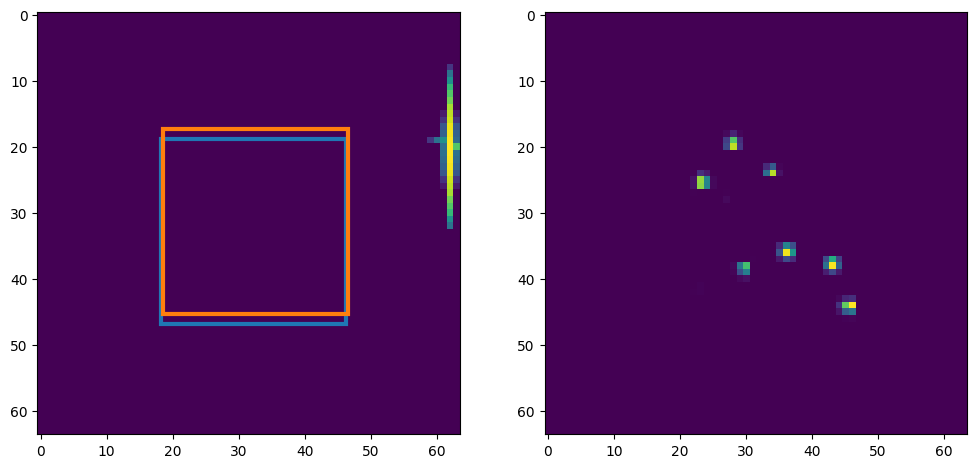

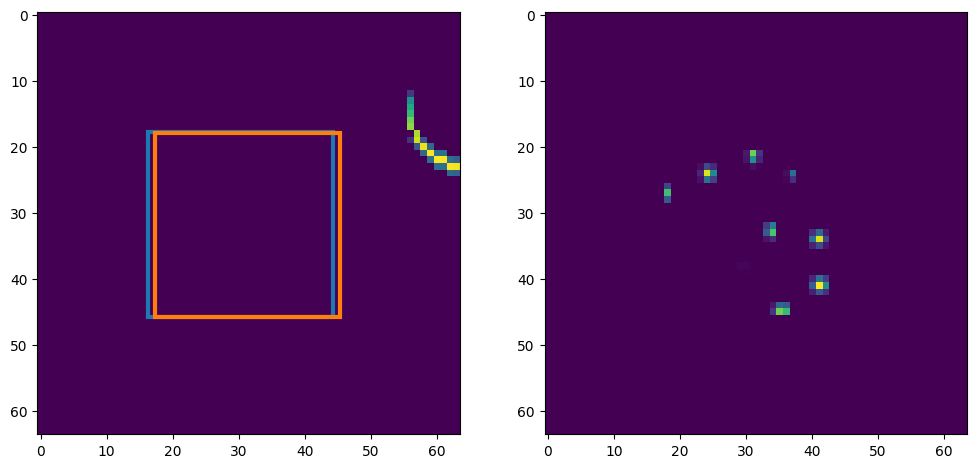

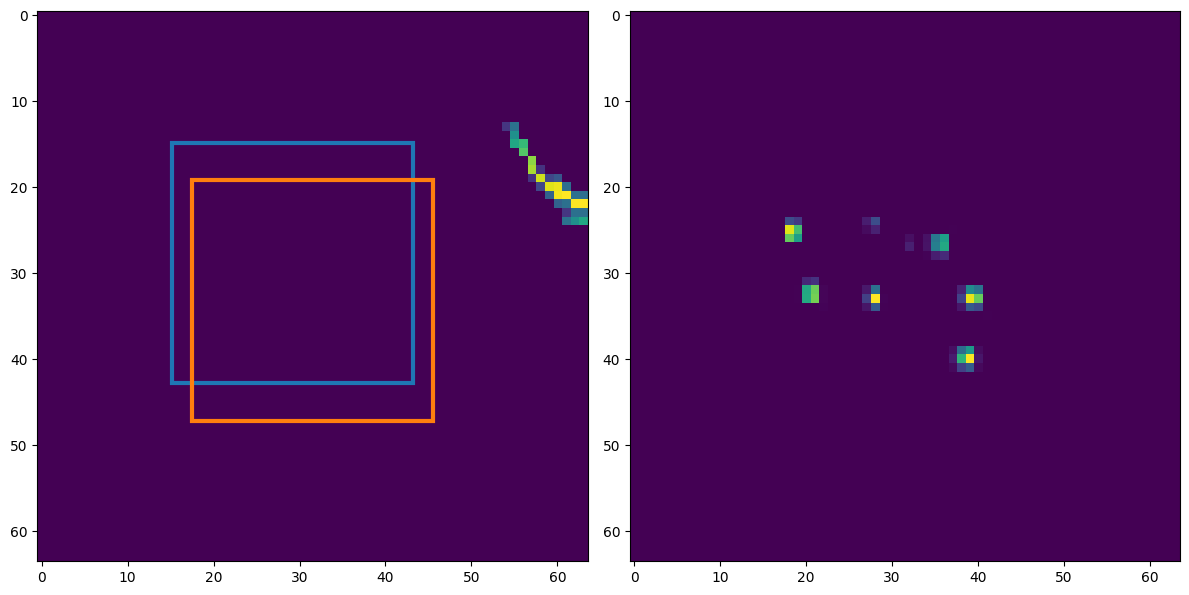

In [ ]:
b = 0
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
def animate(i):
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))
  axes[0].cla()
  axes[0].imshow(test_data[b, i])
  axes[1].cla()
  axes[1].imshow(out["frames_recon"][0, b, i])
  for d in range(2):
    foo = out[f"z_where_{i}"][0, b, d]
    # foo = jnp.array([-1, 1])
    print(foo)
    where = 0.5 * (foo + 1) * (frame_size - 28) - 0.5
    print(where)
    color = colors[d]
    axes[0].add_patch(
        Rectangle(where, 28, 28, edgecolor=color, lw=3, fill=False)
    )
for i in range(10):
  animate(i)
plt.rc("animation", html="jshtml")
plt.tight_layout()
# ani = animation.FuncAnimation(fig, animate, frames=range(10), interval=300)
# writer = animation.PillowWriter(fps=15)
# ani.save("wormsim.gif", writer=writer)
# plt.show()


In [ ]:
i = 0
b = 3
d = 0
where = 0.5 * (out[f"z_where_{i}"][0, b, d] + 1) * (frame_size - 14) - 0.5

In [ ]:
where

Array([22.788496, 22.36769 ], dtype=float32)

In [ ]:
out[f"z_where_{i}"][0, b, d]

Array([-0.06846014, -0.08529241], dtype=float32)

In [ ]:
where

Array([22.788496, 22.36769 ], dtype=float32)

In [ ]:
out.keys()

dict_keys(['frames', 'frames_recon', 'worm_frames', 'worms', 'z_where_0', 'z_where_1', 'z_where_2', 'z_where_3', 'z_where_4', 'z_where_5', 'z_where_6', 'z_where_7', 'z_where_8', 'z_where_9'])

In [ ]:
network = coix.util.BindModule(wormsim_net, wormsim_params)

In [ ]:
test_data.shape

(5, 10, 64, 64)

In [ ]:
wormsim_params['params']['encode_where']['Dense_0']['kernel'].shape

(1369, 200)

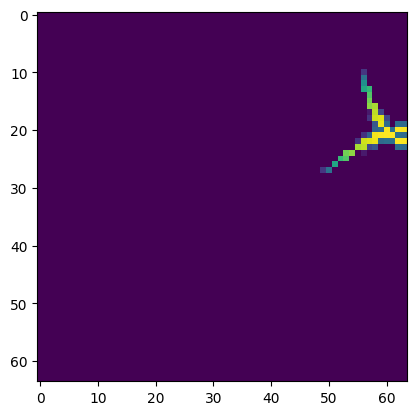

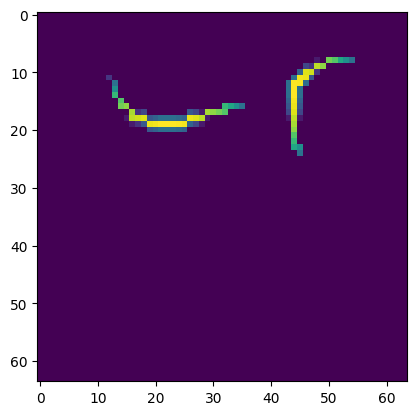

In [ ]:
plt.figure()
plt.imshow(test_data[0, 0])
plt.figure()
plt.imshow(test_data[1, 1])

In [ ]:
bar, bar_scale = network.encode_where(np.random.randn(51, 51))
print(bar)
print(bar_scale)
print(0.5 * (bar[0] + 1) * (frame_size - 14) - 0.5, 0.5 * (bar[1] + 1) * (frame_size - 14) - 0.5)

ScopeParamShapeError: Initializer expected to generate shape (1369, 200) but got shape (2601, 200) instead for parameter "kernel" in "/encode_where/Dense_0". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamShapeError)

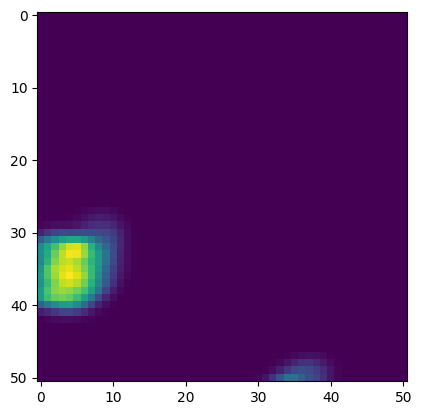

In [ ]:
plt.imshow(conv2d(test_data[0, 0], digit_mean))

In [ ]:
bar = network.encode_where(conv2d(test_data[0, 0], digit_mean))
print(0.5 * (bar[0] + 1) * (frame_size - 14) - 0.5, 0.5 * (bar[1] + 1) * (frame_size - 14) - 0.5)
bar = network.encode_where(conv2d(test_data[1, 1], digit_mean))
print(0.5 * (bar[0] + 1) * (frame_size - 14) - 0.5, 0.5 * (bar[1] + 1) * (frame_size - 14) - 0.5)

[35.51287  16.244263] [25.65173  25.610958]
[35.582787 16.252335] [25.632355 25.591904]


In [ ]:
out_z_where = jnp.stack([out[f"z_where_{i}"] for i in range(10)], -2)
digits = crop_frames(test_data_tiled, out_z_where, 14)
gru_out = network.encode_what(digits)

In [ ]:
seeded_kernel_what = numpyro.handlers.seed(kernel_what, jax.random.PRNGKey(0))
tr = numpyro.handlers.trace(seeded_kernel_what)(network, out, T=10)

In [ ]:
duration = 0.55
snapshots = 10
kpoints = 6
box_size = 64

sim_fn = partial(
    worm_simulation,
    duration=duration,
    snapshots=snapshots,
    kpoints=kpoints,
)

In [ ]:
gru_out[4][0, 4]

Array([0.78426397, 0.78426397], dtype=float32)

In [ ]:
out["worms"][0, 0, 0, 3, :]

Array([[-0.2868712 , -0.2035813 ],
       [-0.20549005, -0.04836779],
       [-0.09899499,  0.0908189 ],
       [ 0.02353141,  0.2161242 ],
       [ 0.15186606,  0.33547387],
       [ 0.27518308,  0.46000105]], dtype=float32)

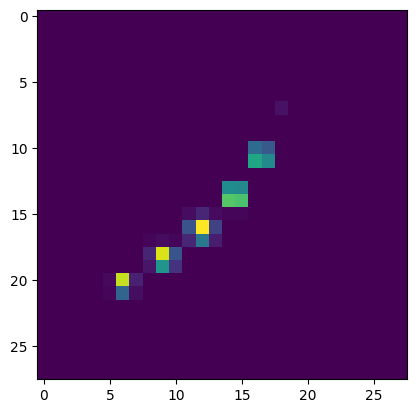

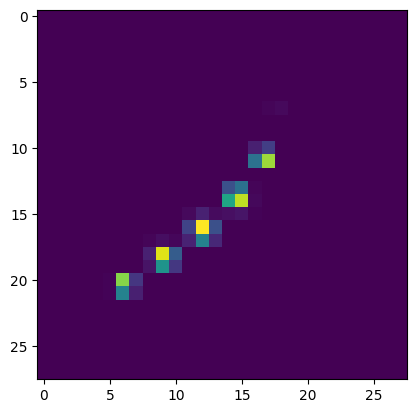

In [ ]:
plt.figure()
plt.imshow(out["worm_frames"][0, 0, 0, 0, :, :])
plt.figure()
plt.imshow(out["worm_frames"][0, 0, 0, 5, :, :])

In [ ]:
# network = coix.util.BindModule(wormsim_net, wormsim_params)

# out_z_where = jnp.stack([out[f"z_where_{i}"] for i in range(10)], -2)